# Creating a Graph Convolutional Network (GCN) model 
In this small assignment, I created a Graph Convolutional Network (GCN) model using a small network dataset. The model was created without using any graph-based deep learning library. The main libraries that were used are Pytorch and Networkx.

In [24]:
import pandas as pd 
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pdb

# Create data 

For this assignment I used a small network data from the “Zachary’s karate club” problem. The karate club is a social network that includes 34 members and documents pairwise links between members who interact outside the club. The club later divides into two communities led by the instructor (node 0) and the club president (node 33).

The task is to predict which side (0 or 33) each member tends to join given the social network itself. This task can be seen as a semi-supervised learning problem, because only the instructor and the club president are assigned labels. The nodes and edges are given below.

In [25]:
nodes = list(range(34))
edges = [(0, 8), (1, 17), (24, 31), (13, 33), (0, 1), (2, 8), (0, 19), 

 (25, 31), (14, 33), (0, 2), (2, 9), (1, 19), (28, 31), (15, 33), 

 (1, 2), (0, 10), (0, 21), (2, 32), (18, 33), (0, 3), (4, 10), 

 (1, 21), (8, 32), (19, 33), (1, 3), (5, 10), (23, 25), (14, 32), 

 (20, 33), (2, 3), (0, 11), (24, 25), (15, 32), (22, 33), (0, 4), 

 (0, 12), (2, 27), (18, 32), (23, 33), (0, 5), (3, 12), (23, 27), 

 (20, 32), (26, 33), (0, 6), (0, 13), (24, 27), (22, 32), (27, 33), 

 (4, 6), (1, 13), (2, 28), (23, 32), (28, 33), (5, 6), (2, 13), 

 (23, 29), (29, 32), (29, 33), (0, 7), (3, 13), (26, 29), (30, 32), 

 (30, 33), (1, 7), (5, 16), (1, 30), (31, 32), (31, 33), (2, 7), 

 (6, 16), (8, 30), (8, 33), (32, 33), (3, 7), (0, 17), (0, 31), 

 (9, 33)]



# Visualize the Graph
Using the edges given above, I visualized the network graph. For the visualization I also used the networkx library of python.
For more information about this library you can visit the following link: https://networkx.github.io/documentation/networkx-1.9/index.html

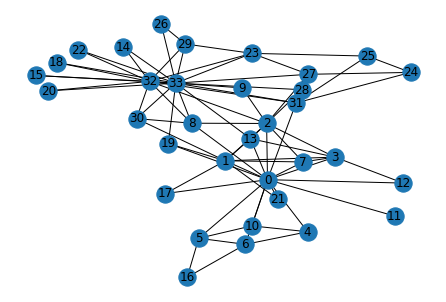

In [26]:
g = nx.Graph()
g.add_nodes_from(nodes)
src, dst = tuple(zip(*edges))
edges2 = list(zip(list(dst),list(src)))
all_edges = edges + edges2 
g.add_edges_from(all_edges)
nx.draw(g, with_labels = True)

# Create GCN layer 

Mathematically, the propagation in the GCN model follows this formula:

$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$

At each layer, each node carries a feature vector. Each layer of the GCN tries to aggregate the features from the neigbor nodes into the next layer. This is followed by an transformation with an activation function. This is also known as message passing and is somewhere similar to pooling in Convolutional Neural Networks (CNNs). 

Here, 
- $H^{(l)}$ denotes the $l^{th}$ layer in the network,
- $\sigma$ is the non-linearity (activation function),
- $W$ represents the weight matrix for this layer. ($N \times F$),
- $D$ represents degree matrix ($N \times N$ with on the diagonal the degree per node),
- $A$ represents the adjacency matrix ($N \times N$).

$N$ represents the number of nodes and $F$ the number of features per node. The ~ is a normalization trick in which we add a self-connection to each node of the graph, and build the corresponding degree and adjacency matrix. During the multiplication, for every node, we sum up all the feature vectors of all neighboring nodes but not the node itself. This can be fixed by enforcing self-loops in the graph. Furthermore, nodes with large degrees will have lgetarge values in their feature representation while nodes with small degrees will have small values. This can be problematic for algorithms like gradient descent. Therefore, we need to normalize the adjacency matrix $A$ by multiplying it with the inverse of the degree matrix $D^{-1}$.

Forward propagation for a GCN layer looks like this:
- Set input features for all nodes,
- Ask each node to send its features across all its edges,
- At each destination node, update features to the sum of source node features,
- Apply a non-linear transformation (e.g. Sigmoid, ReLu) to reduce dimensionality.

Below I made the following functions/classes: 
- get_inputs: This function creates the desired input matrixes for the propagation
- gcn_propagate: This function is for the propagation rule
- GCNLayer: This class constructs the GCN layers by randomly initializing the weights and applying the propagation rule. GCNs associate features with nodes and edges for training. Since there is no input feature for this classification example, I assigned each node with a learnable weight vector.

In [27]:
def get_inputs(g):
    I = torch.eye(g.number_of_nodes()) # The identity matrix 34*34
    A = torch.tensor(nx.to_numpy_matrix(g)) #The adjacency matrix 34x34
    D = A - I # The degree matrix 34x34
    A_hat = A + I # Add self-loops to each node 
    D_hat = A_hat.sum(dim=1) #Degree matrix of A_hat
    D_hat = torch.diag_embed(D_hat) 
    return A_hat, D_hat

In [28]:
def gcn_propagate(G, X, W):
    # G = The network graph
    # X = Input features
    # W = Weight matrix
    A_hat, D_hat = get_inputs(G)
    A_hat = A_hat.float()
    D_hat = D_hat.float()
    A_norm = torch.matmul(A_hat,torch.inverse(D_hat)) #Normalizing A such that all rows sum to one
    sec_half = torch.matmul(A_norm,X) #second half of the propagation rule
    final = torch.matmul(sec_half,W) #final part of the propagation rule
    return final

In [29]:
class GCNLayer(nn.Module):
    def __init__(self, feat_in,feat_out):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(feat_in,feat_out)).float()

    def forward(self, G, X):
        y = gcn_propagate(G,X,self.weight)
        return y

# Create GCN model

For the GCN module, I decided to create a GCN with 1 hidden layer. The input layer contains 34 features per node. The hidden layer contains 10 features per node.  For the output I used a softmax layer to classify the nodes into the two groups. Furthermore, I used ReLu as an activation function.

In [30]:
class GCN(nn.Module):
    def __init__(self, feat_in, hidden_size, num_of_classes): 
        super(GCN,self).__init__()
        self.fc1 = GCNLayer(feat_in, hidden_size)
        self.fc2 = GCNLayer(hidden_size, num_of_classes)
        self.output = nn.Softmax()
        
    def forward(self, G):
        I = torch.eye(G.number_of_nodes()).float()
        x = self.fc1(G, I)
        x = F.relu(x)
        x = self.fc2(G, x)
        x = F.relu(x)
        x = self.output(x)
        return x

In [37]:
model = GCN(34, 10, 2)
labeled_nodes = torch.tensor([0,33])
labels = torch.tensor([0,1])

# Train GCN

The training loop itself is as usual:
- Run forward propagation on the graph and its inputs,
- Compute the loss between predictions and labels (only for labeled nodes),
- Run backpropagation, and update layer weights.

In [43]:
optimizer = torch.optim.Adam(model.parameters())
all_preds = []
epochs = 100

for epoch in  range(epochs):
    preds = model(g)
    all_preds.append(preds)
    
    #compute the loss for labeled notes
    loss = F.cross_entropy(preds[labeled_nodes], labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

C:\Users\reven\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch 0 | Loss: 0.5103
Epoch 1 | Loss: 0.5102
Epoch 2 | Loss: 0.5103
Epoch 3 | Loss: 0.5100
Epoch 4 | Loss: 0.5100
Epoch 5 | Loss: 0.5100
Epoch 6 | Loss: 0.5099
Epoch 7 | Loss: 0.5099
Epoch 8 | Loss: 0.5098
Epoch 9 | Loss: 0.5098
Epoch 10 | Loss: 0.5097
Epoch 11 | Loss: 0.5096
Epoch 12 | Loss: 0.5096
Epoch 13 | Loss: 0.5095
Epoch 14 | Loss: 0.5094
Epoch 15 | Loss: 0.5094
Epoch 16 | Loss: 0.5093
Epoch 17 | Loss: 0.5092
Epoch 18 | Loss: 0.5092
Epoch 19 | Loss: 0.5091
Epoch 20 | Loss: 0.5090
Epoch 21 | Loss: 0.5090
Epoch 22 | Loss: 0.5089
Epoch 23 | Loss: 0.5088
Epoch 24 | Loss: 0.5088
Epoch 25 | Loss: 0.5087
Epoch 26 | Loss: 0.5086
Epoch 27 | Loss: 0.5086
Epoch 28 | Loss: 0.5085
Epoch 29 | Loss: 0.5084
Epoch 30 | Loss: 0.5084
Epoch 31 | Loss: 0.5083
Epoch 32 | Loss: 0.5083
Epoch 33 | Loss: 0.5082
Epoch 34 | Loss: 0.5081
Epoch 35 | Loss: 0.5081
Epoch 36 | Loss: 0.5080
Epoch 37 | Loss: 0.5080
Epoch 38 | Loss: 0.5079
Epoch 39 | Loss: 0.5078
Epoch 40 | Loss: 0.5078
Epoch 41 | Loss: 0.5077
Ep

# Visualize the results
Now that we obtained the final results, we can visualize it using the networkx package. 

In [44]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)
color = np.where(predicted_class==0, 'c', 'r')
print(predicted_class)
print(color)

[0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
['c' 'c' 'r' 'r' 'c' 'c' 'c' 'c' 'r' 'r' 'r' 'c' 'r' 'r' 'r' 'r' 'c' 'c'
 'r' 'r' 'r' 'c' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r']


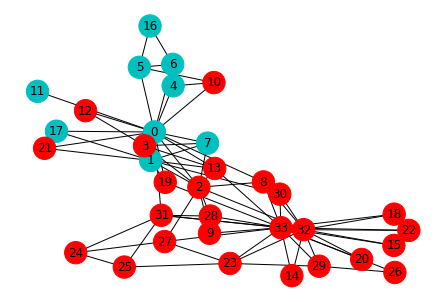

In [40]:
nx.draw(g,  node_color= color, with_labels = True, node_size =500)